# 1. Read data from CSV file

In [2]:
# Import the package pandas as pd
import pandas as pd

# Read the csv file using read_csv method of pandas
prices = pd.read_csv('security_prices_2000_2019.csv', index_col=0)

# Set the index to datetime
prices.index = pd.to_datetime(prices.index)

prices.tail()

,Gold,Silver,Crude Oil,Platinum,Corn,Sugar,Wheat,EUR-USD,USD-JPY,GBP-USD,...,GBP-EUR,S&P500,Dow Jones Industrial Average,NASDAQ,Russell 2000,TLT,TLH,IEF,IEI,SHY
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-26,142.380005,16.73,103.120003,89.510002,14.84,7.01,5.76,1.109545,109.369003,1.297353,...,1.16890,321.052124,283.575867,213.335373,166.037979,136.366409,143.870224,110.003388,125.000992,84.119888
2019-12-27,142.330002,16.58,103.279999,88.879997,14.88,7.05,5.82,1.110112,109.542000,1.300221,...,1.17085,320.972565,283.843536,213.155762,165.221146,136.515533,144.009445,110.162628,125.219879,84.179588
2019-12-30,142.630005,16.74,103.120003,90.129997,14.82,7.08,5.80,1.118230,109.428001,1.309192,...,1.17066,319.202972,282.059174,211.758743,164.802765,136.018463,143.691238,110.092964,125.249718,84.209435
2019-12-31,142.899994,16.68,102.480003,90.930000,14.80,7.02,5.85,1.120230,108.873001,1.311303,...,1.17039,319.978424,282.624176,212.157883,165.031876,134.686310,142.816101,109.694862,125.110435,84.199486
2020-01-01,142.899994,16.68,102.480003,90.930000,14.80,7.02,5.85,1.122083,108.681000,1.326260,...,1.18140,319.978424,282.624176,212.157883,165.031876,134.686310,142.816101,109.694862,125.110435,84.199486


# 2. Calculate correlation coefficient and p-value

In [3]:
# Import numpy
import numpy as np

# Import pearsonr from scipy.stats
from scipy.stats import pearsonr

def calc_corr(df, lookback, hold):
    
    # Create a copy of the dataframe
    data = df.copy()
    
    # Calculate lookback returns
    data['lookback_returns'] = data['price'].pct_change(lookback)
    
    # Calculate hold returns
    data['future_hold_period_returns'] = data['price'].pct_change(hold).shift(-hold)
    
    data = data.dropna()
    data = data.iloc[::hold]
    
    # Calculate correlation coefficient and p-value
    corr, p_value = pearsonr(data.lookback_returns,
                             data.future_hold_period_returns)
    return corr, p_value

# 3. Plot correlation coefficient and p-value

In [4]:
# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
plt.style.use('seaborn-darkgrid')

def plot_grid(data_to_plot, vmin, vmax, cmap, title_name):

    # Plot heatmap and set the style
    fig, ax = plt.subplots(figsize=(10, 7))
    ax = seaborn.heatmap(data_to_plot, cmap=cmap,
                         annot=True, vmin=vmin, vmax=vmax, xticklabels=hold, yticklabels=lookback)
    
    # Adjust top and bottom y-axis
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    # Label the heatmap
    plt.title(title_name, fontsize=14)
    plt.xlabel('Hold', fontsize=12)
    plt.ylabel('Lookback', fontsize=12)
    plt.show()

# 4. Optimal lookback and holding period

In [5]:
# Define lookback periods
lookback = [15, 30, 60, 90, 150, 240, 360]

# Define holding periods
hold = [5, 10, 15, 30, 45, 60]

# Create a dataframe which stores price of a security
crude_data = pd.DataFrame()
crude_data['price'] = prices['Crude Oil']
crude_data.dropna()

# Create an array of length lookback*hold
corr_grid = np.zeros((len(lookback), len(hold)))
p_value_grid = np.zeros((len(lookback), len(hold)))

# Run through a length of lookback and holding periods
for i in range(len(lookback)):
    for j in range(len(hold)):

        # Call calc_corr function and calculate correlation coefficient and p-value
        corr_grid[i][j], p_value_grid[i][j] = calc_corr(
            crude_data, lookback[i], hold[j])

## Plot correlation coefficient

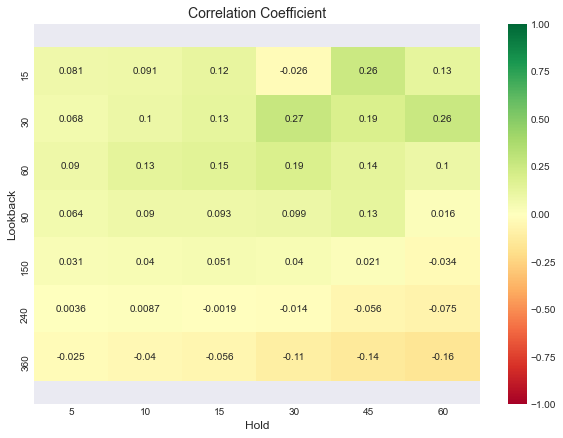

Lookback Optimal: 30
Hold Optimal: 30


In [6]:
# Call plot_grid function and plot correlation cofficient
plot_grid(corr_grid, vmin=-1, vmax=1, cmap='RdYlGn',
          title_name='Correlation Coefficient')

# Find maximum value of correlation coefficient
opt = np.where(corr_grid == np.max(corr_grid))

# Find the optimal lookback and holding period
opt_lookback = lookback[opt[0][0]]
opt_hold = hold[opt[1][0]]
print('Lookback Optimal:', opt_lookback)
print('Hold Optimal:', opt_hold)

## Plot p-value

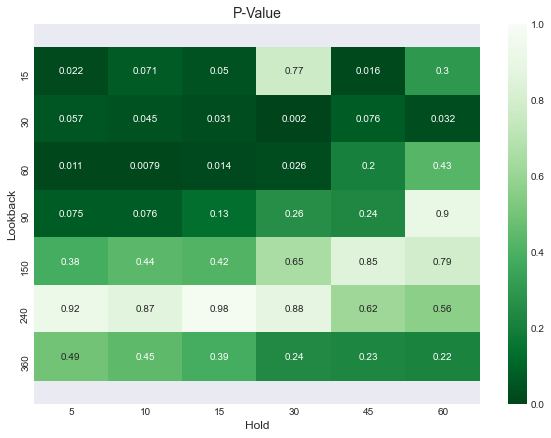

In [7]:
# Call plot_grid function and plot p-value
plot_grid(p_value_grid, vmin=0, vmax=1, cmap='Greens_r', title_name='P-Value')

# 5. Calculate Strategy Returns

In [8]:
def calc_returns(data, lookback, hold, title_name):

    # Calculate returns over a lookback period
    data['lookback_returns'] = data['price'].pct_change(lookback)

    # Calculate future returns
    data['future_hold_period_returns'] = data['price'].pct_change(hold).shift(-hold)

    # Define strategy logic
    data['positions'] = np.where(data['lookback_returns'] > 0, 1, -1)

    data = data.dropna()
    data = data.iloc[::hold]

    # Calculate strategy returns
    data['strategy_returns'] = data['future_hold_period_returns'] * data['positions']
    cum_rets = (data['strategy_returns']+1).cumprod()
    
# ------------------------------------------------------------------------------------    

    # Calculate Sharpe ratio
    sharpe = (np.mean(data['strategy_returns']) /
              np.std(data['strategy_returns'])*((252/hold)**0.5))
    print(title_name + ' Sharpe Ratio:', sharpe)

# ------------------------------------------------------------------------------------    

    # Plot and lable the graphs
    fig = plt.figure(figsize=(16, 7))    
    sub = fig.add_subplot(1, 2, 1)
    cum_rets.plot()
    sub.set_ylabel('Cumulative Returns', fontsize=12)
    sub.set_xlabel('Date', fontsize=12)
    
# ------------------------------------------------------------------------------------        

    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = ((cum_rets)/running_max - 1)

    # Plot drawdown
    sub = fig.add_subplot(1, 2, 2)    
    drawdown.plot(color='r') 
    sub.set_ylabel('Returns',fontsize=12)
    sub.set_xlabel('Date',fontsize=12)
    plt.show()

Crude Oil Sharpe Ratio: 0.6026755170936188


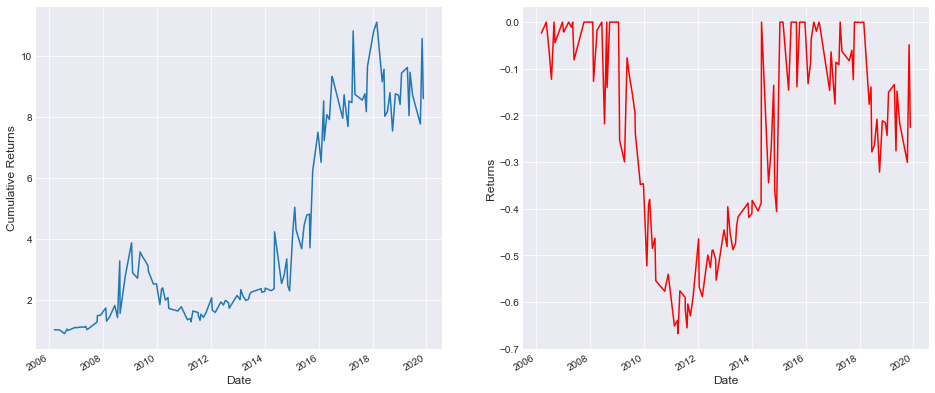

In [9]:
# Pass Crude oil data with optimal lookback and holding period
calc_returns(crude_data, 30, 30, 'Crude Oil')

# 6. Optimal lookback and holding period for all securities

In [10]:
# Create a dataframe which stores the correlation coefficient and p-value
corr_pvalue = pd.DataFrame()

# Create a dataframe which stores price data of all securities
data = pd.DataFrame()

# Securities with Hurst exponent greater than 0.65
price = prices[['Crude Oil', 'NASDAQ', 'SHY', 'Wheat', 'Gold', 'Sugar', 'IEF', 'Russell 2000',
                'IEI', 'S&P500', 'Dow Jones Industrial Average', 'Silver', 'Corn', 'TLH', 'TLT', 'USD-JPY']]

for column in price.columns:
    data['price'] = price[column]

    # Run through a length of lookback and holding period
    for i in range(len(lookback)):
        for j in range(len(hold)):

            # Calculate correlation coefficient and p-value
            corr, p_value = calc_corr(data, lookback[i], hold[j])

            # Append correlation and p-value in a dataframe
            corr_pvalue = corr_pvalue.append(
                [[column, lookback[i], hold[j], corr, p_value]])

corr_pvalue.columns = ['Instrument', 'Lookback',
                       'Hold', 'Correlation', 'P_value']

# Set index of corr_pvalue dataframe
corr_pvalue.reset_index(inplace=True, drop=True)
corr_pvalue.head()

,Instrument,Lookback,Hold,Correlation,P_value
0,Crude Oil,15,5,0.081360,0.021780
1,Crude Oil,15,10,0.090693,0.071065
2,Crude Oil,15,15,0.120492,0.050072
3,Crude Oil,15,30,-0.025718,0.769743
4,Crude Oil,15,45,0.256214,0.015974


## Filter securities based on correlation coefficient and p-value

In [11]:
corr_pvalue_filtered = corr_pvalue.loc[(
    corr_pvalue['Correlation'] > 0) & (corr_pvalue['P_value'] < 0.1)]

corr_pvalue_filtered.head()

,Instrument,Lookback,Hold,Correlation,P_value
0,Crude Oil,15,5,0.081360,0.021780
1,Crude Oil,15,10,0.090693,0.071065
2,Crude Oil,15,15,0.120492,0.050072
4,Crude Oil,15,45,0.256214,0.015974
6,Crude Oil,30,5,0.067539,0.057450


## Lookback and hold period with the highest correlation

In [12]:
# Keep lookback and holding period with highest correlation
max_correlation = corr_pvalue_filtered.groupby(
    ['Instrument'])['Correlation'].transform(max) == corr_pvalue_filtered['Correlation']


corr_pvalue_filtered[max_correlation]

,Instrument,Lookback,Hold,Correlation,P_value
9,Crude Oil,30,30,0.266490,0.002011
71,NASDAQ,150,60,0.195152,0.059441
125,SHY,360,60,0.400568,0.000279
340,IEI,15,45,0.183089,0.097568
380,S&P500,15,15,0.108672,0.032804
467,Silver,15,60,0.240030,0.052229
508,Corn,15,45,0.320113,0.011903


# 7. Calculate strategy returns for all securities

Crude Oil Sharpe Ratio: 0.6026755170936188


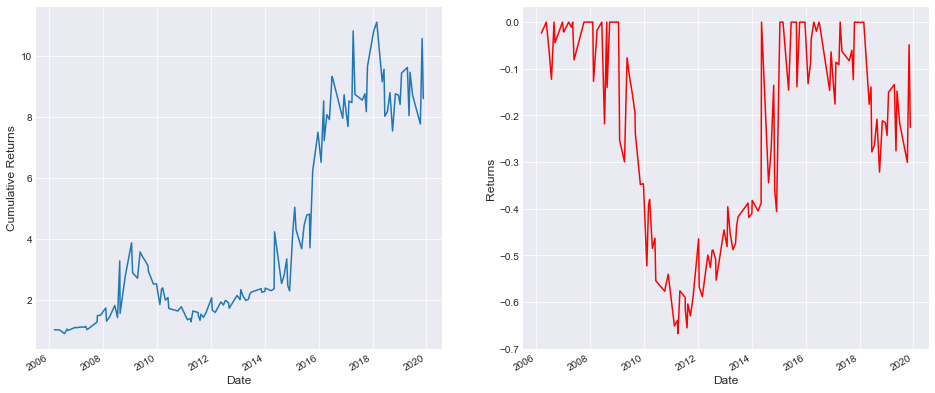

NASDAQ Sharpe Ratio: 0.20283290398158932


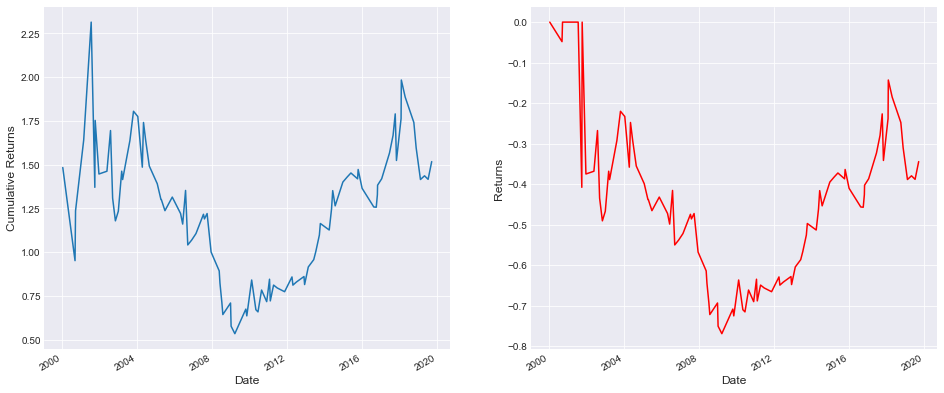

SHY Sharpe Ratio: 1.2218438432242007


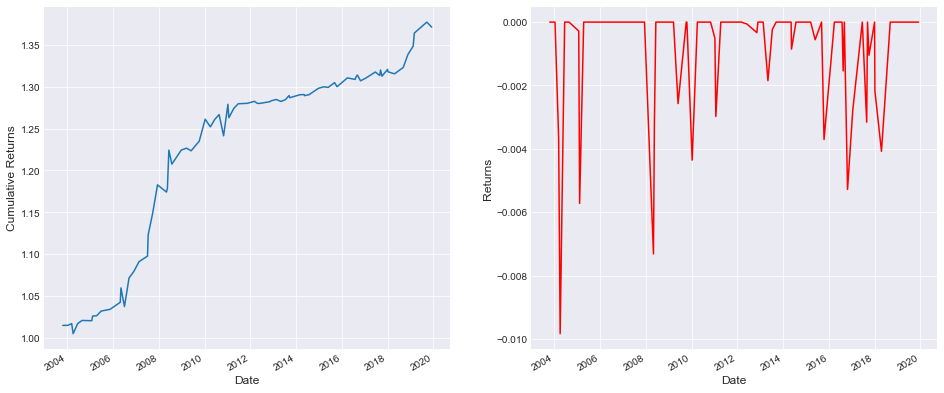

IEI Sharpe Ratio: 0.43645646934347576


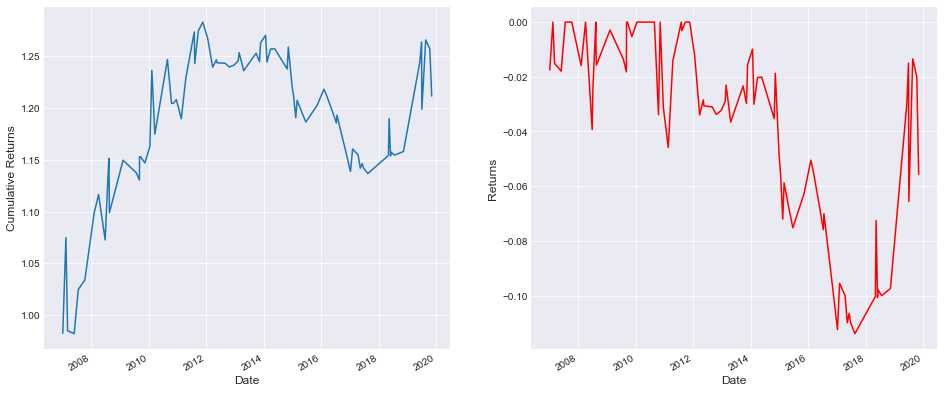

S&P500 Sharpe Ratio: 0.27856396653992793


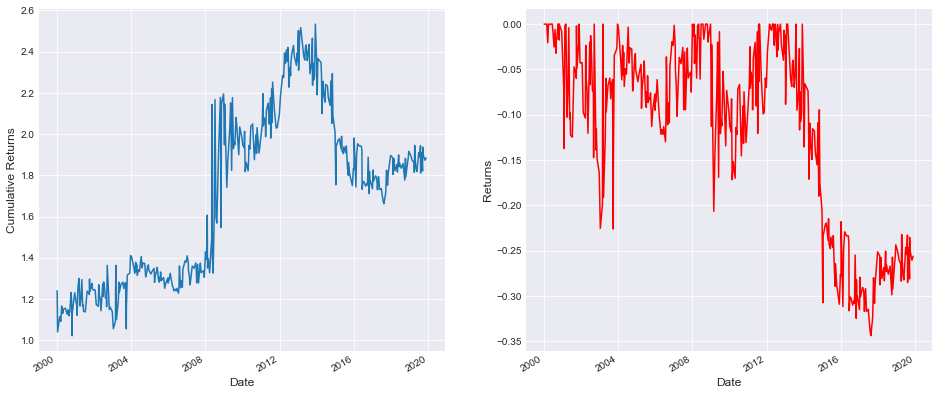

Silver Sharpe Ratio: 0.3890970155253028


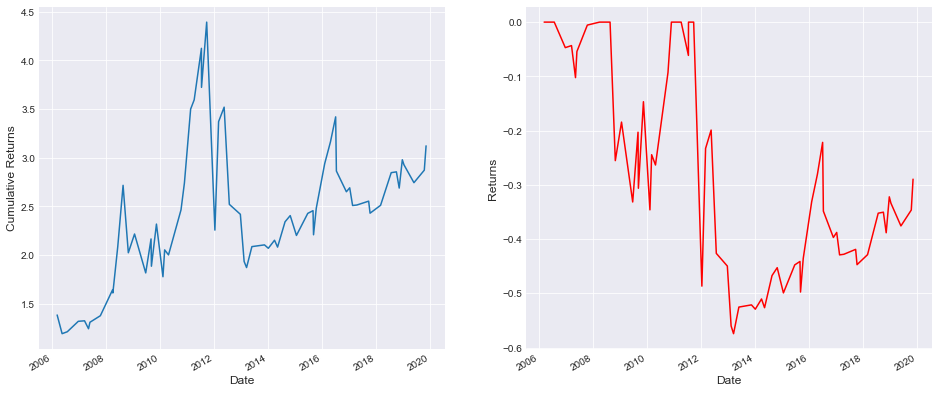

Corn Sharpe Ratio: 0.317976937553598


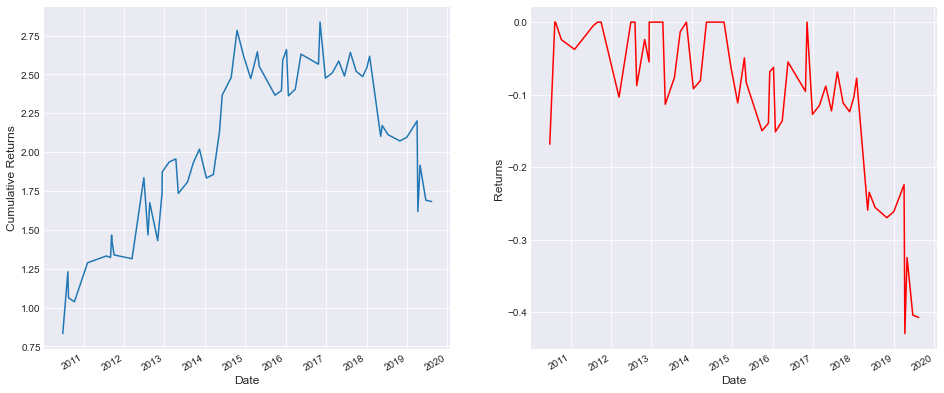

In [14]:
# Run through index of corr_pvalue_filtered[max_correlation] and call the 'calc_returns' function  
for i in corr_pvalue_filtered[max_correlation].index:

    instrument = corr_pvalue_filtered[max_correlation].loc[i, 'Instrument']
    lookback = corr_pvalue_filtered[max_correlation].loc[i, 'Lookback']
    hold = corr_pvalue_filtered[max_correlation].loc[i, 'Hold']
    data['price'] = price[instrument]
    
    calc_returns(data, lookback, hold, instrument)